In [123]:
%matplotlib inline

import sys

sys.path.append("..")

In [113]:
import os
import io
import json
import h5py
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import PIL
import torch
from functions_sqoop import generate_in_sample, evaluate_activations, read_output_files, LongTailSampler
from vr.models.shnmn import _shnmn_func
from analyze_models import data_name, load_data_, feats_to_image, retrieve_id_repeated_experiments
from torch.autograd import Variable
import torch.nn.functional as F
from vr.utils import load_execution_engine, load_program_generator
from train_model import get_execution_engine
from vr.utils import load_vocab
from vr.data import ClevrDataset, ClevrDataLoader
from train_model import check_accuracy

# Data generation for in-sample test data

We generate a new dataset and respect the distribution used at training. Data path contains all the data folders for 2 and 5 objects per image.

In [114]:
root_path = './../../..'

In [115]:
# 1st index : 2 or 5 objects per image
# 2nd index : lhs configurations

data_path = join(root_path, 'datasets', data_name[2][18])  

In [5]:
# generate_in_sample(data_path, output_path=data_path)

# Load model and give a hand-crafted example

**X, R, Y**: are the idx for 1st object, relation and 2nd object  
**posx**: list of two values containing (x,y) coordinates for 1st object: given the dimensions of the object fixed at 10, it does not make sense to go out of the range [5, 59]  
**posy**: same as posx for the 2nd object, avoid overlap  
**path_vocab_dataset**: path to the vocabulary  
**path_model**: folder containing the results  
**model_file**: model name

In [ ]:
path_ = join(root_path, 'datasets', data_name[2][1])
path_vocab_dataset = join(path_, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)
path_model = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs1')
lst_slurm_file = [f_ for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]
model_file = lst_slurm_file[0] 

**NOTE**  
If you want to retrieve questions, making new ones, all you have to do is using the vocab

In [ ]:
question_words = ['A', 'above', 'D']

question_idx = [vocab_dataset['question_token_to_idx'][q_] for q_ in question_words]
print(question_idx)
question_token = [vocab_dataset['question_idx_to_token'][q_] for q_ in question_idx]

In [ ]:
img_, _, pred = evaluate_activations(X=22, R=45, Y=31, pos_x=[5,5], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=model_file)

In [ ]:
plt.imshow(img_[0][1])
plt.show()
pred

Each column here refers to a module (1) sentinel=0, (2) feature output from stem, (3) module X, (4) module Y, and (5) module (R). The number of rows if fixed at 64.

# Different modular architectures

### Common to all
\begin{align}
\gamma_k = \sum_{i=1}^3 \alpha^{k,i} e(q_i) \\
s_k^m = \sum_{j=-1}^{k-1}\tau_m^{k,j}s_j \\
s_k = f(\theta, \gamma_k, s_k^0, s_k^1) \\
h_{qx} = s_3
\end{align}

### Residual
\begin{align}
[W_1^k; b_1^k; W_2^k; b_2^k; W_3^k; b_3^k] = \gamma_k \\
\tilde{s}_k = \text{ReLU}(W_3^k* [s^1_k, s^0_k] + b_3^k) \\
f_{\text{Res}}(\gamma_k, s_k^0, s_k^1) = \text{ReLU}(\tilde{s}_k + W_1^k * \text{ReLU}(W_2^k * \tilde{s}_k+ b_2^k))+b_1^k)
\end{align}

**a module for each question**

### Find
\begin{align}
[W_1; b_1; W_2; b_2] = \theta \\
f_{\text{Find}}(\theta, \gamma_k, s_k^0, s_k^1) = \text{ReLU}(W_1 * \gamma_k \odot \text{ReLU}(W_2*[s^0_k, s^1_k]+b_2)+b_1)
\end{align}

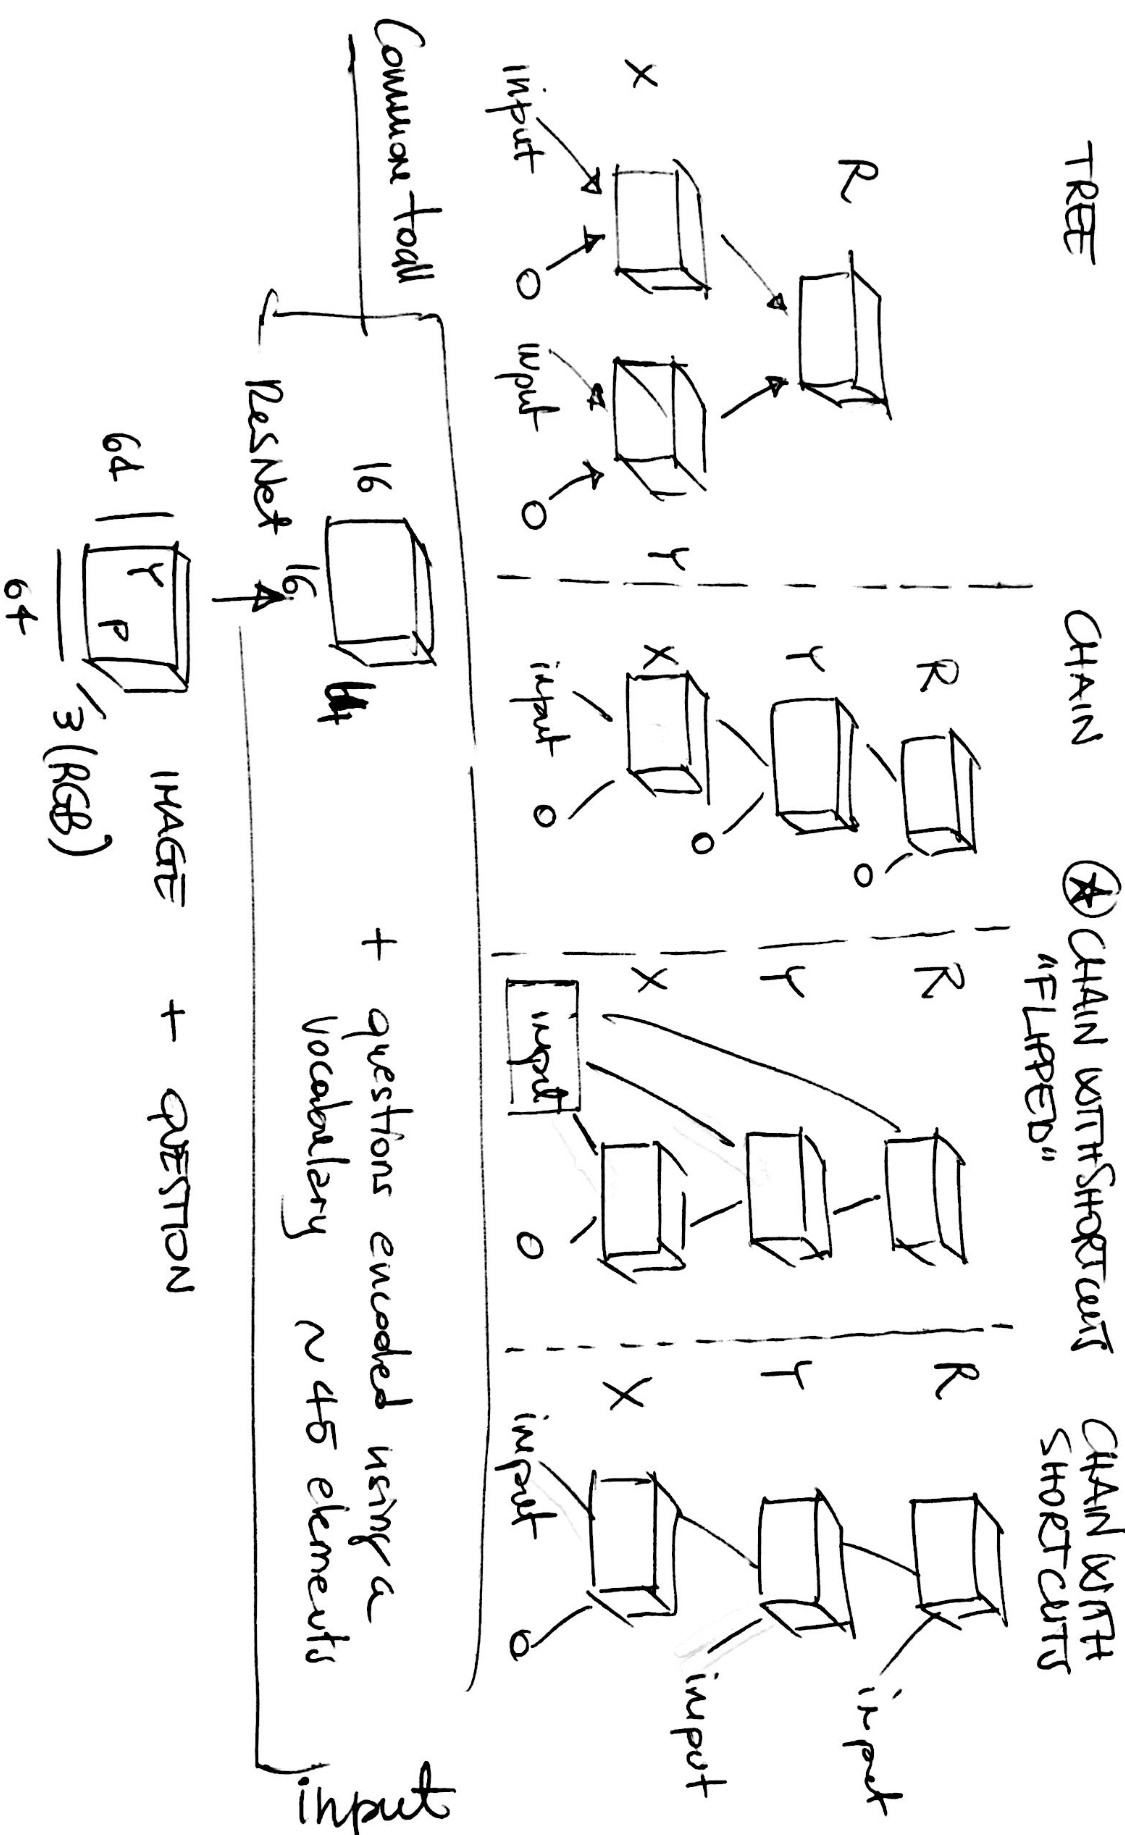

In [6]:
from IPython.display import Image
Image(filename='IMG_8609.jpg')

# Testing in and out of samples

To visualize activations, and normalize the network we use **in sample configurations** - same questions at training and test

To evaluate systematic generalization, we consider **out of sample configurations**



## Chain w shortcuts: original and flipped versions on 1 lhs

Original

In [116]:
path_ch_sh = join(root_path, 'systematic-generalization-sqoop_2objects/results/chain_w_shortcuts_models_2objs/residual/lhs1')
output_in_sample = [join(path_ch_sh, f_) for f_ in os.listdir(path_ch_sh) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_ch_sh, f_) for f_ in os.listdir(path_ch_sh) if (not f_.startswith('output_in_sample') and
                                                             f_.startswith('output'))]

In [117]:
read_output_files(slurm_id_lst=None, path_output=output_in_sample)  # in sample, error approach zeros

array([0.        , 0.00203252, 0.00016938, 0.        , 0.00186314])

In [118]:
test_out_original = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(test_out_original)
print(np.mean(test_out_original), np.std(test_out_original))

[0.32401961 0.30686275 0.35375817 0.30669935 0.33366013]
0.325 0.01770234621859366


Flipped version

In [ ]:
path_ch_flp_sh = join(root_path, 'systematic-generalization-sqoop_2objects/results/chain_w_shortcuts_flipped_models_2objs/residual/lhs1')
output_in_sample = [join(path_ch_flp_sh, f_) for f_ in os.listdir(path_ch_flp_sh) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_ch_flp_sh, f_) for f_ in os.listdir(path_ch_flp_sh) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [ ]:
read_output_files(slurm_id_lst=None, path_output=output_in_sample)

In [ ]:
test_out_flipped = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(test_out_flipped)
print(np.mean(test_out_flipped), np.std(test_out_flipped))

## Tree architecture: difference between residual and find

### Residual - 1 lhs

In [ ]:
path_tree = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs1')
output_in_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [ ]:
read_output_files(slurm_id_lst=None, path_output=output_in_sample) 

In [ ]:
print(read_output_files(slurm_id_lst=None, path_output=output_out_sample))
out_ = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
np.mean(out_), np.std(out_)

### Residual - 18 lhs

In [ ]:
path_ = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18')
output_in_sample = [join(path_, f_) for f_ in os.listdir(path_) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_, f_) for f_ in os.listdir(path_) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [ ]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(out_)
np.mean(out_), np.std(out_)

For a larger number of configurations, the residual module with the tree architecture recovers approximately 100% accuracy at test

# Systematic generalization

### Trained on 2 objects, tested on 5, lhs 18, residual

In [ ]:
path_ = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18')
output_5obj = [join(path_, f_) for f_ in os.listdir(path_) if f_.startswith('output_5obj')]

In [ ]:
print(path_)

In [ ]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_5obj)
print(out_)
np.mean(out_), np.std(out_)

### Trained on 2 objects, tested on 5, lhs 1, residual

In [ ]:
path_ = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs1')
output_5obj = [join(path_, f_) for f_ in os.listdir(path_) if f_.startswith('output_5obj')]

In [ ]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_5obj)
print(out_)
np.mean(out_), np.std(out_)

The architecture fails to generalize

### Trained on 5 objects, tested on 2, lhs 1, residual

In [ ]:
path_ = '/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train'
output_2obj = [join(path_, f_) for f_ in os.listdir(path_) if f_.startswith('output_2obj')]

In [ ]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_2obj)
print(out_)
np.mean(out_), np.std(out_)

### Find - 1 lhs 

In [119]:
path_tree = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs1')
output_in_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [120]:
in_ = read_output_files(slurm_id_lst=None, path_output=output_in_sample)
print(in_)
np.mean(in_), np.std(in_)

[0.         0.         0.         0.         0.00050813]


(0.000101626016260159, 0.000203252032520318)

In [121]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(out_)
np.mean(out_), np.std(out_)

[0.16666667 0.12794118 0.16143791 0.15490196 0.14133987]


(0.15045751633986928, 0.014093797938477821)

### Find - 18 lhs 

In [ ]:
path_tree = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs18')
output_in_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_tree, f_) for f_ in os.listdir(path_tree) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [ ]:
in_ = read_output_files(slurm_id_lst=None, path_output=output_in_sample)
print(in_)
np.mean(in_), np.std(in_)

In [ ]:
out_ = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(out_)
np.mean(out_), np.std(out_)

## Take home: find and residual @ lhs 1

For lhs = 1, and 2 objects, they show different performance, the module type is important. 

For lhs 18 the two perform almost equivalently

# Report precomputed activation maps 

Compute the activation maps for each example in the test_in_sample 

['G', 'left_of', 'T']
['G', 'left_of', 'T']
['G', 'left_of', 'T']
['0', 'left_of', '2']
['G', 'left_of', 'T']
['0', 'left_of', '2']
['0', 'left_of', '2']
['R', 'left_of', 'Q']
['0', 'left_of', '2']


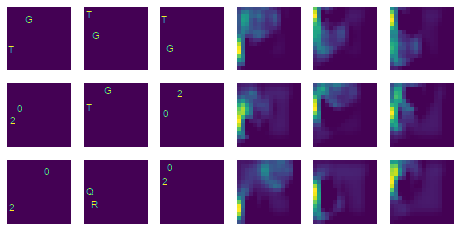

In [140]:
lhs = 1  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'residual'  # residual or find for tree, otherwise residual
objs_per_image = 2

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_%iobjects/results' % objs_per_image,
                  '%s_models_%iobjs' % (model_type, objs_per_image),
                  module_type,
                  'lhs%i' %lhs)

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)


slurm_id = 0  # one of the five experiments
module = 2  # 0=X, 1=Y, 2=R
dim_ = 50  # one of the 64 feature maps

lst_slurm_files = [f_.split('.')[0] for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]
max_activations_idx = np.load(join(path_model, '%s_idx_images.npy' % lst_slurm_files[slurm_id]))
activation_maps = np.load(join(path_model, '%s_activation_maps.npy' % lst_slurm_files[slurm_id]))
_, module_dim, top_n, map_dim, _ = activation_maps.shape

fig, ax = plt.subplots(figsize=(8,4), ncols=top_n//3 * 2, nrows=top_n//3)
for i_, (top_map, id_image) in enumerate(zip(activation_maps[module, dim_, :, :, :],
                                             max_activations_idx[:, module, dim_])):
    print([vocab_dataset['question_idx_to_token'][q_] for q_ in quests[id_image]])
    img = feats_to_image(feats[id_image])
    ax[i_ // 3, i_ % 3].imshow(img[1])
    ax[i_ // 3, 3 + i_ % 3].imshow(top_map)
    ax[i_ // 3, i_ % 3].axis('off')
    ax[i_ // 3, 3 + i_ % 3].axis('off')

plt.savefig('activations_top_9_relational_module_tree_res_2objs_lhs1.pdf')
plt.show()

In [141]:
activation_maps.shape

(3, 64, 9, 16, 16)

# Merge normalization and interaction

1) We generate a test sample by specifying objects involved and question. We are free to move the objects around and to switch the question.

2) We report the normalized activation maps for the image, where the normalization is based on the in-sample-test data

3) We report for each filter the top 9 activating images

In [142]:
from functions_sqoop import generate_scene_dataset, evaluate_activations

lst_slurm_file = [f_ for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]
model_file = lst_slurm_file[slurm_id] 

In [143]:
images, questions = generate_scene_dataset(path_vocab_dataset,
                                           obj_x='P',
                                           obj_y='Y',
                                           rel='above',
                                           obj_flip='Y',
                                           flip_question=True)

In [144]:
_, maps, pred = evaluate_activations(X=None, R=None, Y=None,
                                     images=images, 
                                     questions=questions,
                                     path_model=path_model,
                                     model_file=model_file,
                                     gpu_id=0,
                                     normalization=True,
                                     show=False)

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
res shape torch.Size([324, 5, 64, 16, 16])
maps shape (324, 5, 64, 16, 16)


In [145]:
feats, quests, answers = load_data_(data_path, file_str='test_in_sample')
idx_top_activating = np.load(join(path_model, '%s_idx_images.npy' %model_file.split('.')[0]))

In [146]:
def p_maps_(x, y, feat_num, module, flip, flip_question):
    fig, ax = plt.subplots(2, 8,figsize=(16,4))
    for kk in range(8):
        ax[0][kk].imshow(images[flip_question, flip, y, x, 1])
        ax[0][kk].axis('off')     
    # for k in range(2):
    for kk in range(8):
        ax[1][kk].imshow(maps[flip_question, flip, y, x, module, feat_num*8+kk],
                           vmin=0, vmax=1)
        ax[1][kk].axis('off')   
        plt.subplots_adjust(wspace = .1, hspace = .1)
    plt.show()
    
    if module < 2:
        return
    fig, ax = plt.subplots(6, 12,figsize=(20,10))
    for k in range(2):
        for kk in range(4):
            for count_, idx in enumerate(idx_top_activating[:, module-2, feat_num*8+k*4+kk]):
                feats_ = feats[idx]
                img_ = np.array(PIL.Image.open(io.BytesIO(feats_))).transpose(2, 0, 1) / 255.0
                ax[3 * k + count_//3, 3* kk + count_%3].imshow(img_[1], vmin=0, vmax=0.3)
                ax[3 * k + count_//3, 3* kk + count_%3].axis('off')   
                plt.subplots_adjust(wspace = .1, hspace = .1)
    
    plt.show()

interact(p_maps_, x=widgets.IntSlider(min=0, max=8, step=1, value=0),
         y=widgets.IntSlider(min=0, max=8, step=1, value=0),
         feat_num=widgets.IntSlider(min=0, max=7, step=1, value=0),
         module=widgets.IntSlider(min=0, max=4, step=1, value=0),
         flip=widgets.IntSlider(min=0, max=1, step=1, value=0),
         flip_question=widgets.IntSlider(min=0, max=1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=8), IntSlider(value=0, description='y', max=8), …

<function __main__.p_maps_(x, y, feat_num, module, flip, flip_question)>

In [ ]:
images_, questions_ = generate_scene_dataset(path_vocab_dataset,
                                             obj_x='P',
                                             obj_y='Y',
                                             rel='above',
                                             obj_flip='Z',
                                             flip_question=True)

_, maps_, pred_ = evaluate_activations(X=None, R=None, Y=None,
                                       images=images_, 
                                       questions=questions_,
                                       path_model=path_model,
                                       model_file=model_file,
                                       gpu_id=0,
                                       normalization=True,
                                       show=False)
 
def p_maps(x, y, feat_num, module, flip, flip_q1, flip_q2):
    fig, ax = plt.subplots(4, 8,figsize=(15,5))
    for kk in range(8):
        ax[0, kk].imshow(images[flip_q1, flip, y, x, 1])
        ax[0, kk].axis('off')     
    for kk in range(8):
        ax[1, kk].imshow(maps[flip_q1, flip, y, x, module, feat_num*8+kk],
                           vmin=0, vmax=1)
        ax[1, kk].axis('off')   
        plt.subplots_adjust(wspace = .1, hspace = .1)
    for kk in range(8):
        ax[2, kk].imshow(images_[flip_q2, flip, y, x, 1])
        ax[2, kk].axis('off')     
    for kk in range(8):
        ax[3, kk].imshow(maps_[flip_q2, flip, y, x, module, feat_num*8+kk],
                           vmin=0, vmax=1)
        ax[3, kk].axis('off')   
        plt.subplots_adjust(wspace = .1, hspace = .1)
    
    plt.show()

interact(p_maps, x=widgets.IntSlider(min=0, max=8, step=1, value=0),
         y=widgets.IntSlider(min=0, max=8, step=1, value=0),
         feat_num=widgets.IntSlider(min=0, max=7, step=1, value=0),
         module=widgets.IntSlider(min=0, max=4, step=1, value=0),
         flip=widgets.IntSlider(min=0, max=1, step=1, value=0),
         flip_q1=widgets.IntSlider(min=0, max=1, step=1, value=0),
         flip_q2=widgets.IntSlider(min=0, max=1, step=1, value=0))

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
res shape torch.Size([324, 5, 64, 16, 16])
maps shape (324, 5, 64, 16, 16)


interactive(children=(IntSlider(value=0, description='x', max=8), IntSlider(value=0, description='y', max=8), …

# Object detection

In [125]:
from functions_sqoop import SHAPES, generate_single_object

In [126]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [128]:
img, qst = generate_single_object(SHAPES)

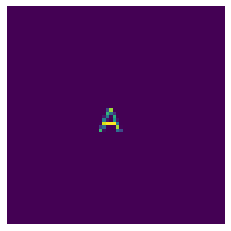

In [131]:
plt.imshow(img[0][1])
# plt.colorbar()
plt.axis('off')
plt.savefig('example_centered_A.pdf')

In [132]:
img_torch = Variable(torch.tensor(np.array(img).astype(np.float32)).to(device))
# print(img_torch.shape)

In [36]:
lhs = 1  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'residual'  # residual or find for tree, otherwise residual
objs_per_image = 2

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_%iobjects/results' % objs_per_image,
                  '%s_models_%iobjs' % (model_type, objs_per_image),
                  module_type,
                  'lhs%i' %lhs)

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)

In [37]:
model_files = [f_ for f_ in os.listdir(path_model) if f_.endswith('pt.best')]

In [38]:
model_files

['17364154_3_.pt.best',
 '17364143_4_.pt.best',
 '17364151_0_.pt.best',
 '17364152_1_.pt.best',
 '17364153_2_.pt.best']

In [39]:
max_maps_across_repetitions = []

for id_model, model_file in enumerate(model_files):

    tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
    if torch.cuda.is_available():
        tree_model.cuda()
    tree_model.eval()

    stem_image = tree_model.stem(img_torch)

    for id_q_, q_ in enumerate(qst):
        question_torch = torch.tensor([[vocab_dataset['question_token_to_idx'][q_] for i_ in range(3)] 
                                       for i in range(len(SHAPES))])
        question_var = Variable(question_torch.to(device))
        question_embedding = tree_model.question_embeddings(question_var)

        res = _shnmn_func(question=question_embedding,
                      img=stem_image.unsqueeze(1),
                      num_modules=tree_model.num_modules,
                      alpha=tree_model.alpha,
                      tau_0=Variable(tree_model.tau_0),
                      tau_1=Variable(tree_model.tau_1),
                      func=tree_model.func)
        maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

        if id_q_ == 0:
            max_maps = np.zeros((len(SHAPES), len(SHAPES), maps.shape[2]))

        max_maps[id_q_] = np.max(maps[:, 2], axis=(2,3))

    # for id_ in range(len(SHAPES)):
    #     for k_ in range(max_maps.shape[-1]):
    #         dividend = max_maps[id_, id_, k_] if max_maps[id_, id_, k_]>= 1e-5 else 1
    #         max_maps[id_, :, k_] = max_maps[id_, :, k_] / dividend

    max_maps_across_repetitions.append(max_maps)

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.


In [40]:
max_maps_across_repetitions = np.array(max_maps_across_repetitions) 

In [18]:
lhs = 1  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'residual'  # residual or find for tree, otherwise residual
objs_per_image = 5

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
path_model = '/om/user/vanessad/om/user/vanessad/original_library/systematic-generalization-sqoop/scripts/train'

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)

In [19]:
dct = {'checkpoint_every': 1000,
       'model_type': 'SHNMN',
       'tau_init': 'tree',
       'hard_code_tau': True, 
       'hard_code_alpha': True,
       'stem_dim': 64,
      }

In [20]:
model_files = ['%s.pt.best' % f_.split('.')[0] 
               for f_ in retrieve_id_repeated_experiments(path_model=path_model, args=dct)]

In [21]:
max_maps_across_repetitions_5obj = []

for id_model, model_file in enumerate(model_files):

    tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
    if torch.cuda.is_available():
        tree_model.cuda()
    tree_model.eval()

    stem_image = tree_model.stem(img_torch)

    for id_q_, q_ in enumerate(qst):
        question_torch = torch.tensor([[vocab_dataset['question_token_to_idx'][q_] for i_ in range(3)] 
                                       for i in range(len(SHAPES))])
        question_var = Variable(question_torch.to(device))
        question_embedding = tree_model.question_embeddings(question_var)

        res = _shnmn_func(question=question_embedding,
                      img=stem_image.unsqueeze(1),
                      num_modules=tree_model.num_modules,
                      alpha=tree_model.alpha,
                      tau_0=Variable(tree_model.tau_0),
                      tau_1=Variable(tree_model.tau_1),
                      func=tree_model.func)
        maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

        if id_q_ == 0:
            max_maps = np.zeros((len(SHAPES), len(SHAPES), maps.shape[2]))

        max_maps[id_q_] = np.max(maps[:, 2], axis=(2,3))

    # for id_ in range(len(SHAPES)):
    #     for k_ in range(max_maps.shape[-1]):
    #         dividend = max_maps[id_, id_, k_] if max_maps[id_, id_, k_]>= 1e-5 else 1
    #         max_maps[id_, :, k_] = max_maps[id_, :, k_] / dividend

    max_maps_across_repetitions_5obj.append(max_maps)

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.


In [22]:
max_maps_across_repetitions_5obj = np.array(max_maps_across_repetitions_5obj)

In [ ]:
max_maps_across_repetitions_5obj.shape

In [ ]:
for other_obj in range(1, 36):
    print(np.argsort(max_maps_across_repetitions_5obj[0, 0, other_obj, :])[:10])
print(np.argsort(max_maps_across_repetitions_5obj[0, 0, 0, :]))

In [ ]:
model_file = model_files[0]

tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
if torch.cuda.is_available():
    tree_model.cuda()
tree_model.eval()

img_torch = torch.tensor(img[0].reshape(1,3,64,64).astype(np.float32))
img_torch = img_torch.to(device)
stem_image = tree_model.stem(img_torch)

quest = ['A', 'A', 'A']
quest = [vocab_dataset['question_token_to_idx'][q_] for q_ in quest]
question_torch = torch.tensor(quest)
question_var = Variable(question_torch.to(device))
question_embedding = tree_model.question_embeddings(question_var)

res = _shnmn_func(question=question_embedding,
              img=stem_image.unsqueeze(1),
              num_modules=tree_model.num_modules,
              alpha=tree_model.alpha,
              tau_0=Variable(tree_model.tau_0),
              tau_1=Variable(tree_model.tau_1),
              func=tree_model.func)
maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

In [ ]:
maps.shape

In [ ]:
plt.imshow(maps[0, 3, 50])
plt.colorbar()

In [ ]:
Image(filename='IMG_8643.jpg')

In [ ]:
rep = 0
obj = 1

for rep in range(5):
    fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=2, sharex='col')
    for i_ in np.delete(np.arange(len(SHAPES)), obj):
        ax[0,0].hist(max_maps_across_repetitions_5obj[rep, obj, i_], alpha=0.5)
        ax[0,1].hist(max_maps_across_repetitions[rep, obj, i_], alpha=0.5)
    ax[0,0].set_title('SQOOP w 5 object')
    ax[0,1].set_title('SQOOP w 2 object')
    ax[1,0].hist(max_maps_across_repetitions_5obj[rep, obj, obj])
    ax[1,1].hist(max_maps_across_repetitions[rep, obj, obj])

## Analysis: does it extend to lhs = 18?

In [13]:
lhs = 18  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'residual'  # residual or find for tree, otherwise residual
objs_per_image = 2

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_%iobjects/results' % objs_per_image,
                  '%s_models_%iobjs' % (model_type, objs_per_image),
                  module_type,
                  'lhs%i' %lhs)

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)

In [14]:
model_files = [f_ for f_ in os.listdir(path_model) if f_.endswith('pt.best')]

In [15]:
model_files

['17384577_2_.pt.best',
 '17384578_3_.pt.best',
 '17384574_4_.pt.best',
 '17384576_1_.pt.best',
 '17384575_0_.pt.best']

In [17]:
max_maps_across_repetitions_lhs18 = []

for id_model, model_file in enumerate(model_files):
    print(join(path_model, model_file))
    tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
    if torch.cuda.is_available():
        tree_model.cuda()
    tree_model.eval()
    
    stem_image = tree_model.stem(img_torch)

    for id_q_, q_ in enumerate(qst):
        question_torch = torch.tensor([[vocab_dataset['question_token_to_idx'][q_] for i_ in range(3)] 
                                       for i in range(len(SHAPES))])
        question_var = Variable(question_torch.to(device))
        question_embedding = tree_model.question_embeddings(question_var)

        res = _shnmn_func(question=question_embedding,
                      img=stem_image.unsqueeze(1),
                      num_modules=tree_model.num_modules,
                      alpha=tree_model.alpha,
                      tau_0=Variable(tree_model.tau_0),
                      tau_1=Variable(tree_model.tau_1),
                      func=tree_model.func)
        maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

        if id_q_ == 0:
            max_maps = np.zeros((len(SHAPES), len(SHAPES), maps.shape[2]))

        max_maps[id_q_] = np.max(maps[:, 2], axis=(2,3))

    # for id_ in range(len(SHAPES)):
    #     for k_ in range(max_maps.shape[-1]):
    #         dividend = max_maps[id_, id_, k_] if max_maps[id_, id_, k_]>= 1e-5 else 1
    #         max_maps[id_, :, k_] = max_maps[id_, :, k_] / dividend

    max_maps_across_repetitions_lhs18.append(max_maps)

./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18/17384577_2_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18/17384578_3_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18/17384574_4_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs18/17384576_1_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   

In [23]:
max_maps_across_repetitions_lhs18 = np.array(max_maps_across_repetitions_lhs18)

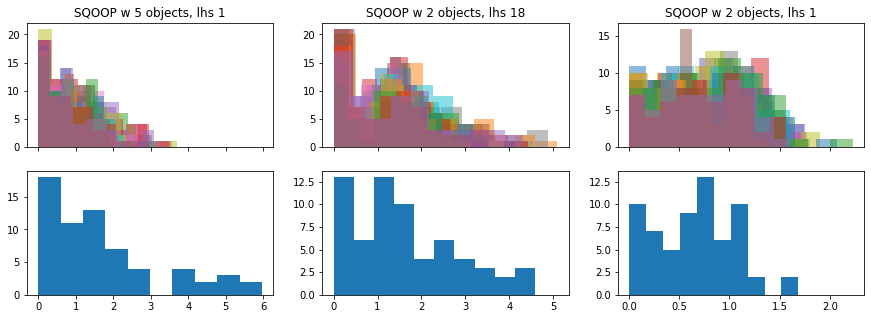

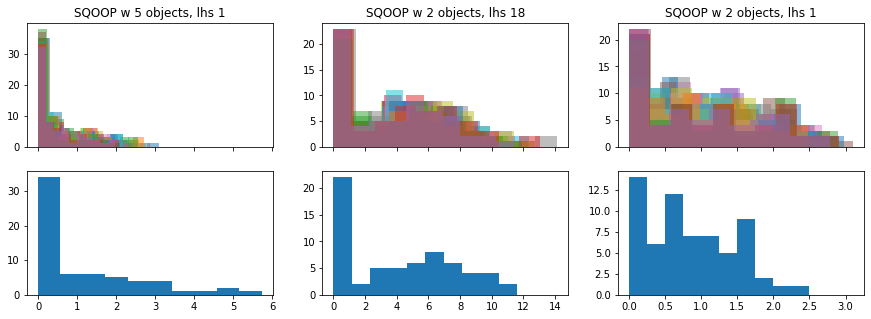

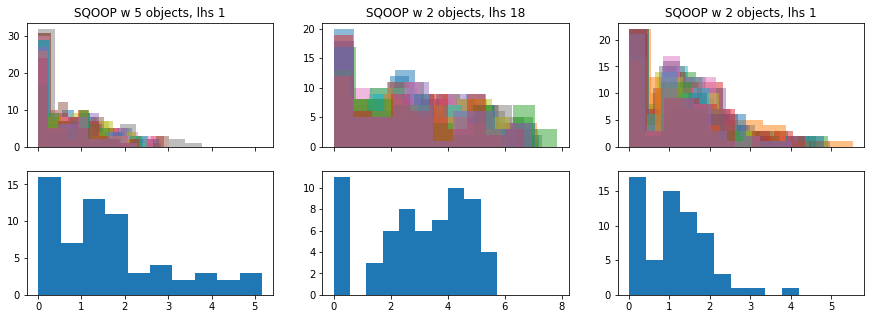

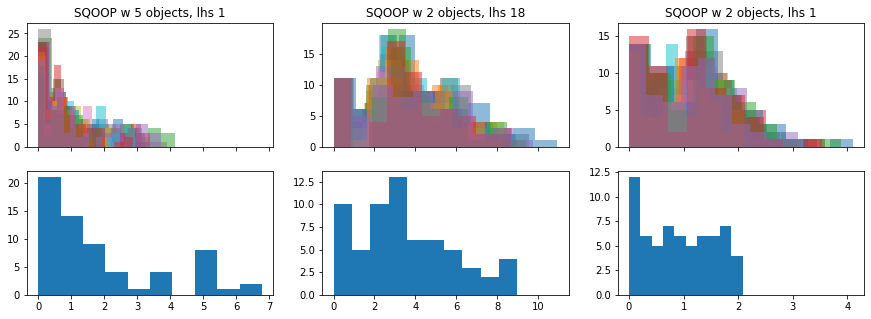

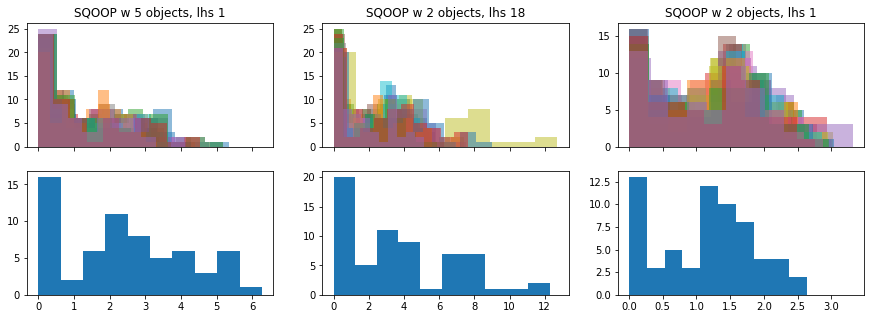

In [135]:
rep = 0
obj = 0

for rep in range(5):
    fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=3, sharex='col')
    for i_ in np.delete(np.arange(len(SHAPES)), obj):
        ax[0,0].hist(max_maps_across_repetitions_5obj[rep, obj, i_], alpha=0.5)
        ax[0,1].hist(max_maps_across_repetitions_lhs18[rep, obj, i_], alpha=0.5)
        ax[0,2].hist(max_maps_across_repetitions[rep, obj, i_], alpha=0.5)
        
    ax[0,0].set_title('SQOOP w 5 objects, lhs 1')
    ax[0,1].set_title('SQOOP w 2 objects, lhs 18')
    ax[0,2].set_title('SQOOP w 2 objects, lhs 1')
    
    ax[1,0].hist(max_maps_across_repetitions_5obj[rep, obj, obj])
    ax[1,1].hist(max_maps_across_repetitions_lhs18[rep, obj, obj])
    ax[1,2].hist(max_maps_across_repetitions[rep, obj, obj])  
    plt.savefig('histogram_repetition_%i.pdf' %rep)

In [33]:
path_max_activation = 'max_activation_values_object_detection'
os.makedirs(path_max_activation, exist_ok=True)

In [34]:
# np.save(join(path_max_activation, 'tree_res_lhs1_obj5.npy'), max_maps_across_repetitions_5obj)

In [35]:
# np.save(join(path_max_activation, 'tree_res_lhs18_obj2.npy'), max_maps_across_repetitions_lhs18)

In [43]:
# np.save(join(path_max_activation, 'tree_res_lhs1_obj2.npy'), max_maps_across_repetitions)

## Find module

In [122]:
lhs = 1  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'find'  # residual or find for tree, otherwise residual
objs_per_image = 2

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_%iobjects/results' % objs_per_image,
                  '%s_models_%iobjs' % (model_type, objs_per_image),
                  module_type,
                  'lhs%i' %lhs)

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)

model_files = [f_ for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]

In [47]:
max_maps_across_repetitions_find_lhs1 = []

for id_model, model_file in enumerate(model_files):
    print(join(path_model, model_file))
    tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
    if torch.cuda.is_available():
        tree_model.cuda()
    tree_model.eval()
    
    stem_image = tree_model.stem(img_torch)

    for id_q_, q_ in enumerate(qst):
        question_torch = torch.tensor([[vocab_dataset['question_token_to_idx'][q_] for i_ in range(3)] 
                                       for i in range(len(SHAPES))])
        question_var = Variable(question_torch.to(device))
        question_embedding = tree_model.question_embeddings(question_var)

        res = _shnmn_func(question=question_embedding,
                      img=stem_image.unsqueeze(1),
                      num_modules=tree_model.num_modules,
                      alpha=tree_model.alpha,
                      tau_0=Variable(tree_model.tau_0),
                      tau_1=Variable(tree_model.tau_1),
                      func=tree_model.func)
        maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

        if id_q_ == 0:
            max_maps = np.zeros((len(SHAPES), len(SHAPES), maps.shape[2]))

        max_maps[id_q_] = np.max(maps[:, 2], axis=(2,3))

    max_maps_across_repetitions_find_lhs1.append(max_maps)

./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs1/17475752_4_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs1/17475755_2_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs1/17475756_3_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs1/17475754_1_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [

In [54]:
max_maps_across_repetitions_find_lhs1 = np.array(max_maps_across_repetitions_find_lhs1)
# np.save(join(path_max_activation, 'tree_find_lhs1_obj2.npy'), max_maps_across_repetitions_find_lhs1)

In [50]:
lhs = 18  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'find'  # residual or find for tree, otherwise residual
objs_per_image = 2

data_path = join(root_path, 'datasets', data_name[objs_per_image][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_%iobjects/results' % objs_per_image,
                  '%s_models_%iobjs' % (model_type, objs_per_image),
                  module_type,
                  'lhs%i' %lhs)

path_vocab_dataset = join(data_path, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)

model_files = [f_ for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]

In [52]:
max_maps_across_repetitions_find_lhs18 = []

for id_model, model_file in enumerate(model_files):
    print(join(path_model, model_file))
    tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
    if torch.cuda.is_available():
        tree_model.cuda()
    tree_model.eval()
    
    stem_image = tree_model.stem(img_torch)

    for id_q_, q_ in enumerate(qst):
        question_torch = torch.tensor([[vocab_dataset['question_token_to_idx'][q_] for i_ in range(3)] 
                                       for i in range(len(SHAPES))])
        question_var = Variable(question_torch.to(device))
        question_embedding = tree_model.question_embeddings(question_var)

        res = _shnmn_func(question=question_embedding,
                      img=stem_image.unsqueeze(1),
                      num_modules=tree_model.num_modules,
                      alpha=tree_model.alpha,
                      tau_0=Variable(tree_model.tau_0),
                      tau_1=Variable(tree_model.tau_1),
                      func=tree_model.func)
        maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

        if id_q_ == 0:
            max_maps = np.zeros((len(SHAPES), len(SHAPES), maps.shape[2]))

        max_maps[id_q_] = np.max(maps[:, 2], axis=(2,3))

    max_maps_across_repetitions_find_lhs18.append(max_maps)

./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs18/17475956_2_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs18/17475955_1_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs18/17475957_3_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
./../../../systematic-generalization-sqoop_2objects/results/tree_models_2objs/find/lhs18/17475954_0_.pt.best
using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
     

In [55]:
max_maps_across_repetitions_find_lhs18 = np.array(max_maps_across_repetitions_find_lhs18)
np.save(join(path_max_activation, 'tree_find_lhs18_obj2.npy'), max_maps_across_repetitions_find_lhs18)

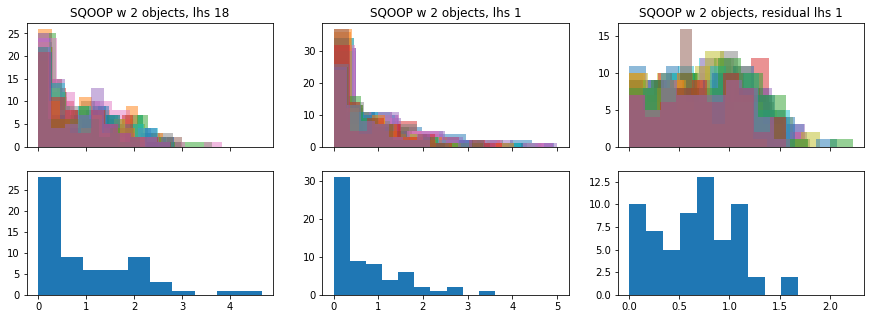

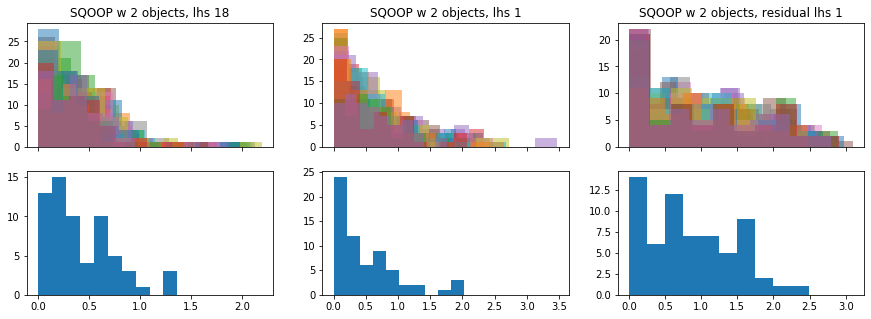

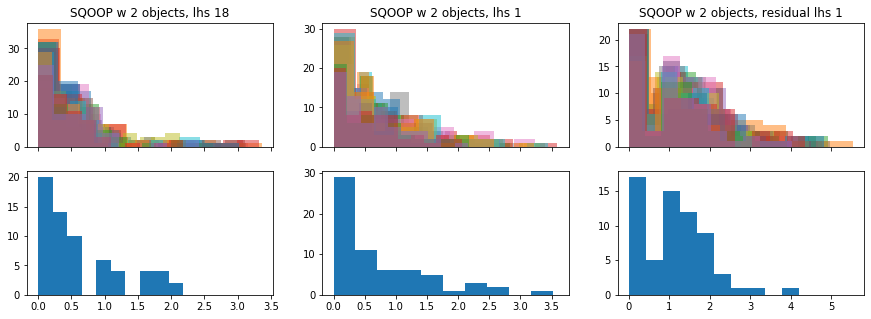

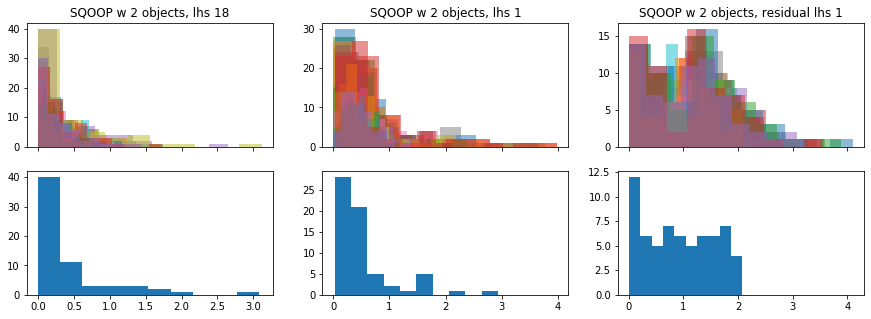

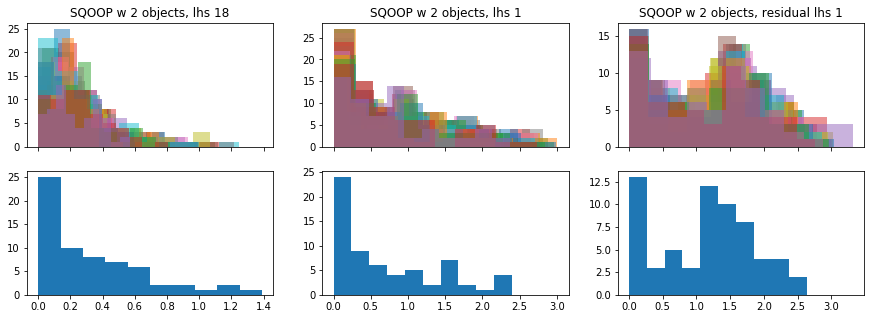

In [137]:
rep = 0
obj = 0

for rep in range(5):
    fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=3, sharex='col')
    for i_ in np.delete(np.arange(len(SHAPES)), obj):
        ax[0,0].hist(max_maps_across_repetitions_find_lhs18[rep, obj, i_], alpha=0.5)
        ax[0,1].hist(max_maps_across_repetitions_find_lhs1[rep, obj, i_], alpha=0.5)
        ax[0,2].hist(max_maps_across_repetitions[rep, obj, i_], alpha=0.5)
    ax[0,0].set_title('SQOOP w 2 objects, lhs 18')
    ax[0,1].set_title('SQOOP w 2 objects, lhs 1')
    ax[0,2].set_title('SQOOP w 2 objects, residual lhs 1')
    
    ax[1,0].hist(max_maps_across_repetitions_find_lhs18[rep, obj, obj])
    ax[1,1].hist(max_maps_across_repetitions_find_lhs1[rep, obj, obj])
    ax[1,2].hist(max_maps_across_repetitions[rep, obj, obj])    
    
    plt.savefig('histogram_find_repetition_%i.pdf' %rep)

For find the question embedding has dimensions 36, 3, 64.
It means that we pick a combination: determined by the vector in the 64 dimensions, of the 36 elements

**We do not see selectivity in general** The histograms for find lhs 18 when the question matches the image overlaps quite well with the case where the scene does not contain the same object of the question

In [103]:
model_file = model_files[0]

tree_model, tree_kwargs = load_execution_engine(join(path_model, model_file))
if torch.cuda.is_available():
    tree_model.cuda()
tree_model.eval()

img_torch = torch.tensor(img[3].reshape(1,3,64,64).astype(np.float32))
img_torch = img_torch.to(device)
stem_image = tree_model.stem(img_torch)

quest = ['D', 'D', 'D']
quest = [vocab_dataset['question_token_to_idx'][q_] for q_ in quest]
question_torch = torch.tensor(quest)
question_var = Variable(question_torch.to(device))
question_embedding = tree_model.question_embeddings(question_var)

res = _shnmn_func(question=question_embedding,
              img=stem_image.unsqueeze(1),
              num_modules=tree_model.num_modules,
              alpha=tree_model.alpha,
              tau_0=Variable(tree_model.tau_0),
              tau_1=Variable(tree_model.tau_1),
              func=tree_model.func)
maps = res.cpu().detach().numpy()  # batch, modules, maps, dim_x, dim_y

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.


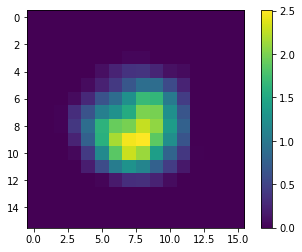

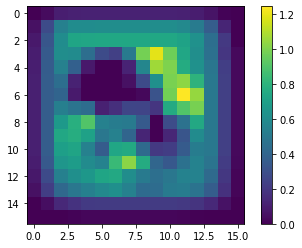

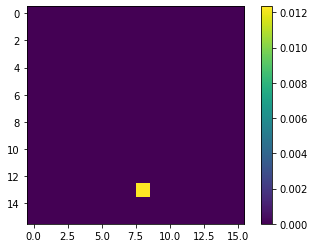

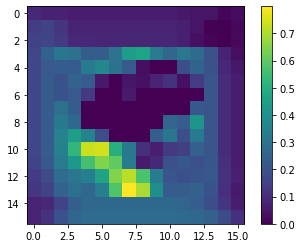

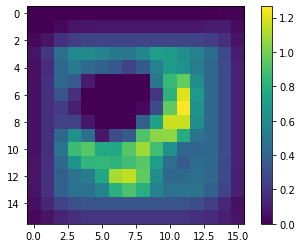

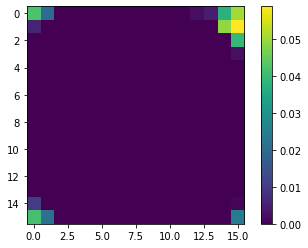

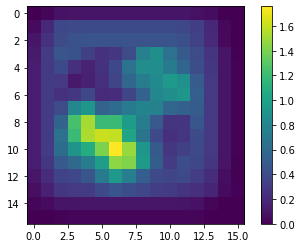

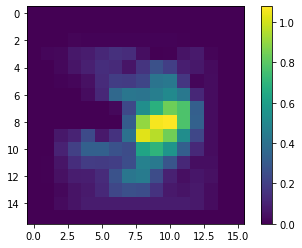

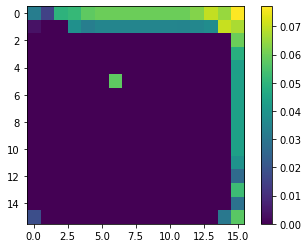

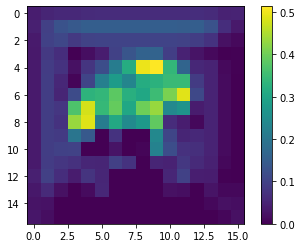

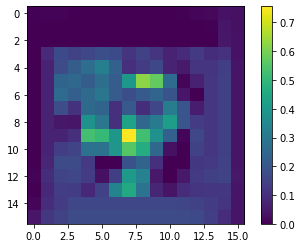

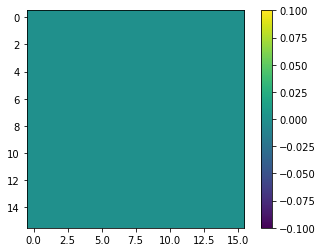

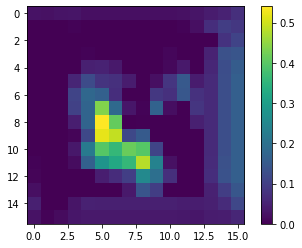

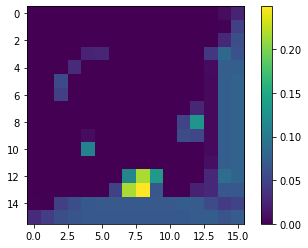

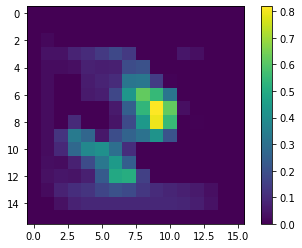

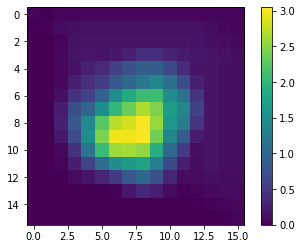

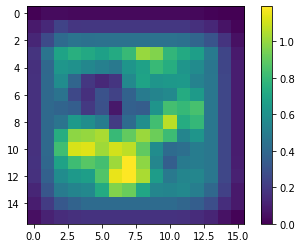

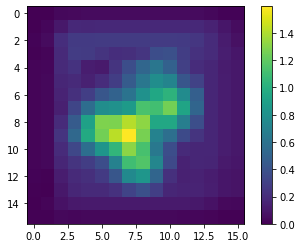

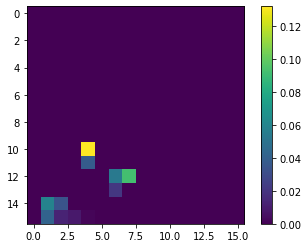

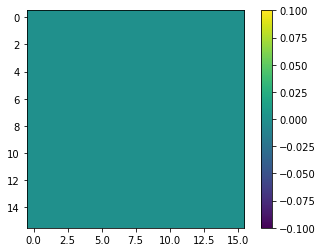

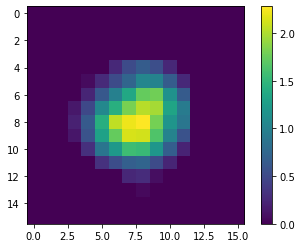

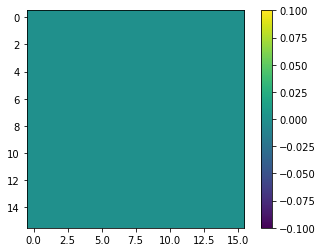

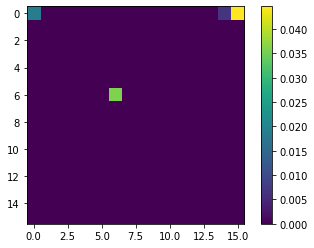

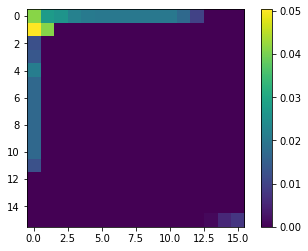

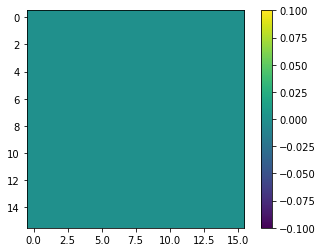

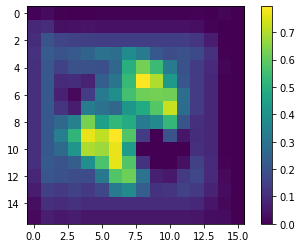

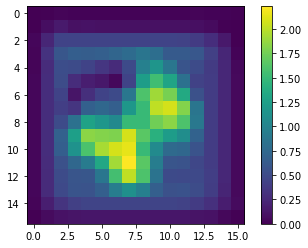

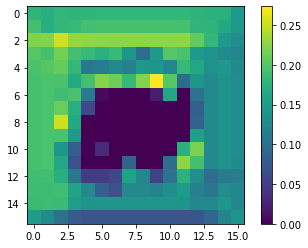

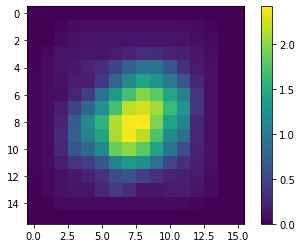

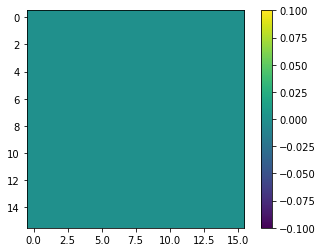

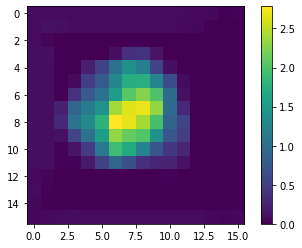

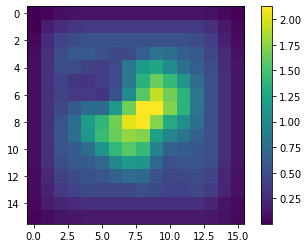

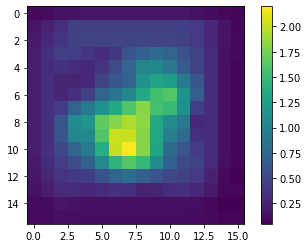

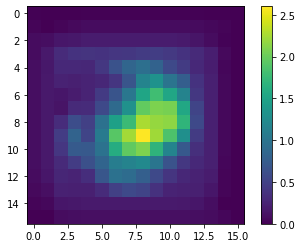

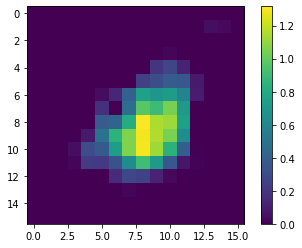

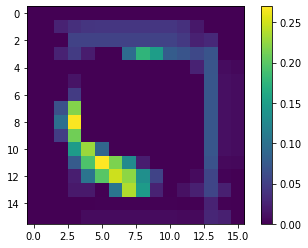

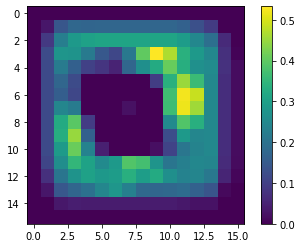

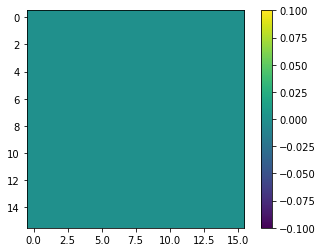

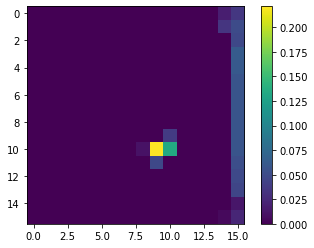

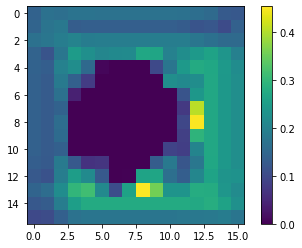

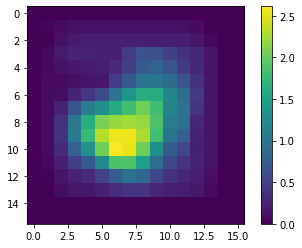

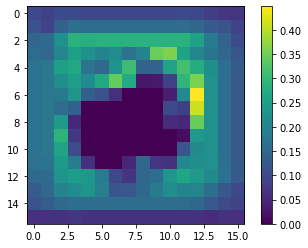

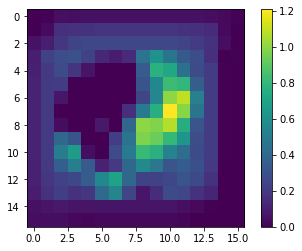

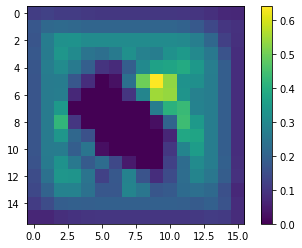

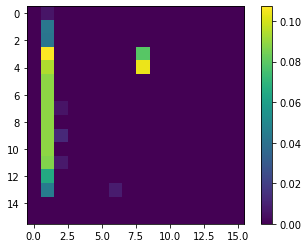

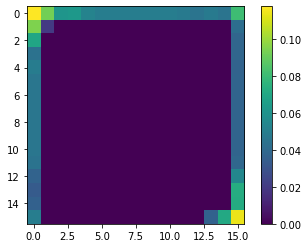

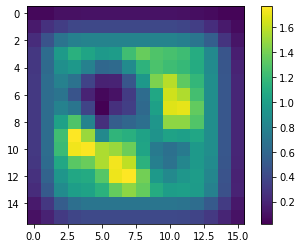

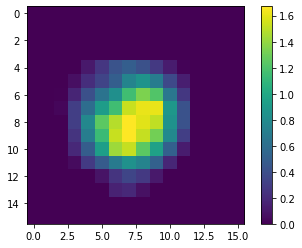

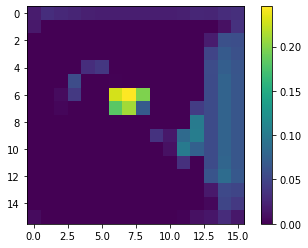

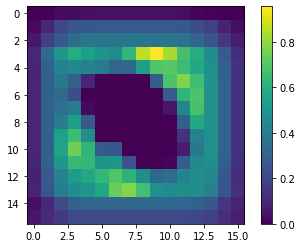

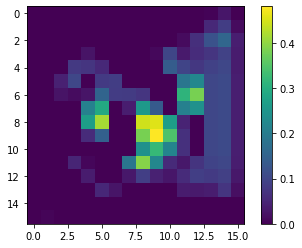

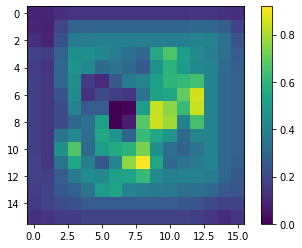

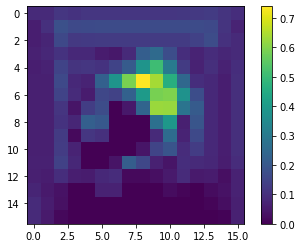

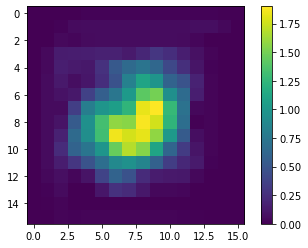

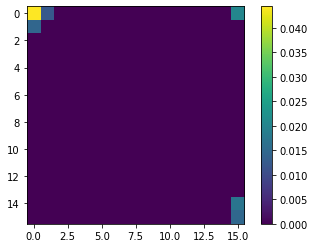

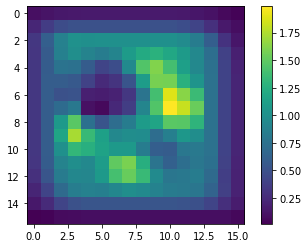

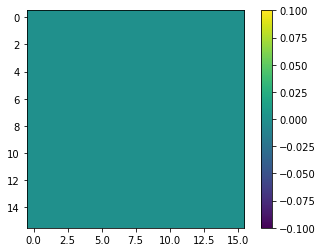

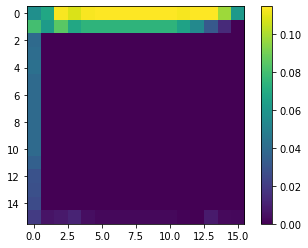

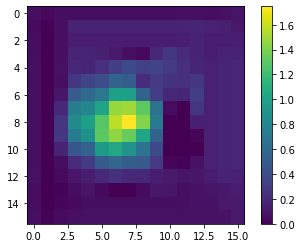

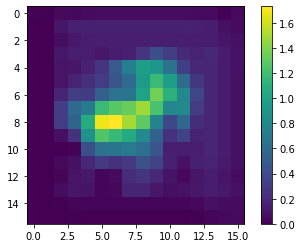

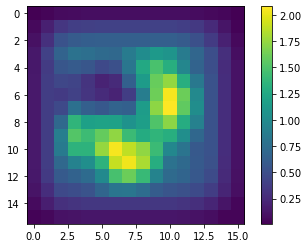

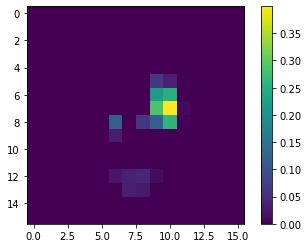

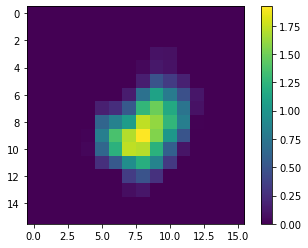

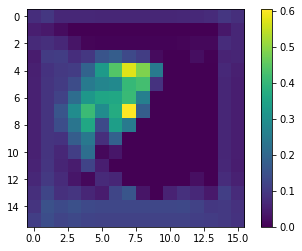

In [109]:
for i in range(64):
    plt.imshow(maps[0, 3, i])
    plt.colorbar()
    plt.show()
    plt.close()

In [110]:
question_embedding.shape

torch.Size([3, 64])

In [111]:
question_embedding

tensor([[-0.4293, -0.9681,  1.4975, -1.2556,  1.3848,  0.0549,  0.3697, -0.6619,
          0.9911,  0.9764, -2.1785,  2.2692,  0.4199,  0.2722, -0.8688,  0.4749,
          0.7209,  0.1386,  0.9240,  1.8049, -1.5416, -0.5104,  0.9839, -0.2272,
         -0.3031,  0.0170,  1.1610,  1.9208, -0.4126, -0.7097,  0.8699, -0.1542,
          0.7057, -0.1022, -0.4224,  1.6438,  0.2974, -1.7828,  0.6487, -0.5361,
          0.2664, -0.5809, -0.7459,  0.0070, -1.2001, -0.9343, -0.1536,  1.1677,
          0.0097,  0.0688, -0.5204,  1.0005, -0.7603,  0.4991,  0.3332,  0.4040,
          0.5108,  0.4328, -0.5563, -0.6368,  0.3795,  0.6249, -1.7402, -1.1451],
        [-0.4293, -0.9681,  1.4975, -1.2556,  1.3848,  0.0549,  0.3697, -0.6619,
          0.9911,  0.9764, -2.1785,  2.2692,  0.4199,  0.2722, -0.8688,  0.4749,
          0.7209,  0.1386,  0.9240,  1.8049, -1.5416, -0.5104,  0.9839, -0.2272,
         -0.3031,  0.0170,  1.1610,  1.9208, -0.4126, -0.7097,  0.8699, -0.1542,
          0.7057, -0.1022, 